In [126]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence as influence
from sklearn.preprocessing import MinMaxScaler
from matplotlib import rcParams
import statsmodels.api as sm
import math
from statsmodels.nonparametric.smoothers_lowess import lowess
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from IPython.display import display, HTML
import re
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')

In [127]:
def import_lar_data(file_path_column_headers, file_path_hmda_lar):

    """
    Needs two inputs : file path for column headers file (.xlsx format) and file path for lar (.csv format)
    """

    lar_headers = pd.read_excel(file_path_column_headers, header = None).T.loc[0]
    lar = pd.read_csv(file_path_hmda_lar, skiprows = 1, header = None,sep='|')
    lar.columns = lar_headers.apply(lambda x: x.replace(' ', '_'))
    lar.columns = [x.replace('-', '_') for x in list(lar.columns)]

    return lar

def extract_ethnicity_fields(lar):
    match_logic_ethnicity = re.compile('Ethnicity_of(_Co)?_Applicant_or_(Co_)?Borrower:_\d')
    ethnicity_fields = list(filter(match_logic_ethnicity.match, lar.columns))
    app_ethnicity_fields = ethnicity_fields[:5]
    co_app_ethnicity_fields = ethnicity_fields[5:]
    return app_ethnicity_fields, co_app_ethnicity_fields


def extract_race_fields(lar):
    match_logic_race = re.compile('Race_of(_Co)?_Applicant_or_(Co_)?Borrower:_\d')
    race_fields = list(filter(match_logic_race.match, lar.columns))
    app_race_fields = race_fields[:5]
    co_app_race_fields = race_fields[5:]
    return app_race_fields, co_app_race_fields

def preprocess_data(lar, fields):
    for field in fields:
        lar[field] = lar[field].astype('string')
        lar[field] = lar[field].fillna('X')
        lar[field] = lar[field].apply(lambda x: x[0])
    return lar

def derive_ethnicity(row, fields):
    for column in fields:
        if row[column] == '1':
            return '1'
    return None

def derive_race(row, fields):
    for column in fields:
        if row[column] != '5' and row[column] != 'X':
            return row[column]
    return None


def calculate_gender(df):
    
    """
    The logic assigns a value of 1 to the 'gender_code' column if either the applicant or the co-applicant identifies as male, and otherwise retains the value from the 'Sex_of_Applicant_or_Borrower' column. 
    """
    
    df['gender_code'] = df.apply(lambda x: 1 if x['Sex_of_Applicant_or_Borrower'] == 1 or x['Sex_of_Co_Applicant_or_Co_Borrower'] == 1 
                                             else x['Sex_of_Applicant_or_Borrower'], axis=1)
    
    gender_dict = {
        1 : 'Male',
        2 : 'Female',
        3 : 'Info Not Provided',
        4 : 'Not Applicable',
        5 : 'No co-Applicant',
        6 : 'Both'
    }
        
    
    df['Gender_Description'] = df['gender_code'].map(gender_dict)
    
    return df



def calculate_age(df):
    
    """
    The logic assigns a value of 'Age 64+' to the 'age_level' column if either the applicant or the co-applicant identifies is over 64, and otherwise assigns a value of 'Under Age 64'.
    """
    
    df['Age_Level'] = df.apply(lambda x: 'Age 64+' if x['Age_of_Applicant_or_Borrower'] in ['65-74', '>74', '8888'] or x['Age_of_Co_Applicant_or_Co_Borrower'] in ['65-74', '>74', '8888']
                                                   else 'Under Age 64', axis=1)
    
    age_dict = {
        '45-54' : 'Under Age 64',
        '35-44' : 'Under Age 64',
        '55-64' : 'Under Age 64',
        '65-74' : 'Under Age 64',
        '25-34' : 'Age 64+',
        '>74'   : 'Age 64+',
        '<25'   : 'Age 64+',
        '8888'  : 'Age Unknown'
    }
        
    
    df['Age_Level'] = df['Age_of_Applicant_or_Borrower'].map(age_dict)
    
    return df

def map_action_taken(action_taken_code):

    """
    Input  : LAR dataframe
    Output : lar dataframe with Action Taken field mapped
    """

    if action_taken_code in [1,2,8]:
        return 'Approved'
    elif action_taken_code in [3, 7]:
        return 'Denied'
    elif action_taken_code == 4:
        return 'Withdrawn'
    elif action_taken_code == 5:
        return 'Closed_Incomplete'
    elif action_taken_code == 6:
        return 'Loan Purchased by your Instituion'
    else:
        return 'Value Not Found'

In [128]:
def merge_race_mapping(df):
    race_mapping = pd.DataFrame({'code':[1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0],
                                 'Race':['American Indian or Alaska Native','Asian','Black',
                                         'Native Hawaiian or Other Pacific Islander','White',
                                         'Information Not Provided','Not Applicable','No Co-Applicant']})
    # Convert 'Race_Calc' to numeric (int), assuming all values are valid integers
    df['Race_Calc'] = pd.to_numeric(df['Race_Calc'], errors='coerce', downcast='integer')

    # Merge using the converted 'Race_Calc' column
    df = df.merge(race_mapping, how='left', left_on='Race_Calc', right_on='code')
    return df




In [129]:
def apply_ethnicity_logic(df):
    # if row['App_Ethnicity'] == 1 or row['Co_App_Ethnicity'] == 1:
    #      return 'Hispanic and Latino'
    # else:
    #      return None
    print(df['App_Ethnicity'].unique())
    for i,r in df.iterrows():
        if r['App_Ethnicity'] == '1' or r['Co_App_Ethnicity'] == '1':
            print('ss')
            df.loc[i,'Race'] = 'Hispanic and Latino'
        else: 
            pass
    return df

In [130]:
def filter_approved_applications(df):

    """
    Input  : LAR dataframe

    Output : lar dataframe with only Approved applications to be used in pricing
    """

    df = df[df_lar['Action_Taken'] == 'Approved'].reset_index(drop=True)
    return df

In [131]:
def pie_chart_population_counts(df, list_protected_features):

    """
    Input  : LAR dataframe
             List of protected features

    Output : Pie charts for Protected Features - Race, Gender and Age Level (Count and percentage for categories with under 10 loan applications will not be shown)
             ** Minority Tract - HMCT/LMCT needs to be added
    """

    for i in list_protected_features:
        df = df[i].value_counts().rename_axis('Protected_Feature_Category').reset_index(name='Count_of_Loan_Applications')

        df.plot.pie(y='Count_of_Loan_Applications',
                    figsize=(5, 5),
                    labeldistance=None,
                    autopct=lambda pct: '{:1.1f}%'.format(pct) if pct > 5 else '',
                    labels=df['Protected_Feature_Category'])

        plt.title('Frequency of Home Loan Applications by {}'.format(i))
        plt.ylabel("")
        plt.legend(bbox_to_anchor=(1,0), loc="center right", fontsize=10,
               bbox_transform=plt.gcf().transFigure)

In [132]:
def probability_density_plots(df):

    """
    Input  : LAR dataframe
             List of protected features

    Output : Density Plots for factor level of protected features - Race, Gender and Age Level
             ** Minority Tract - HMCT/LMCT needs to be added
    """

    fig, ax = plt.subplots(figsize=(6, 6))
    sns.kdeplot(df_lar.loc[df_lar['Race'] == 'White']['Interest_Rate'], fill = True, label='White')
    sns.kdeplot(df_lar.loc[df_lar['Race'] == 'Black']['Interest_Rate'], fill = True, label='Black or African American')
    ax.legend()
    plt.tight_layout()
    plt.title('Loan Density Plot for Black or African American Applicant Race/Ethnicity')
    plt.show()

    fig, ax = plt.subplots(figsize=(6, 6))
    sns.kdeplot(df_lar.loc[df_lar['Race'] == 'White']['Interest_Rate'], fill = True, label='White')
    sns.kdeplot(df_lar.loc[df_lar['Race'] == 'Hispanic and Latino']['Interest_Rate'], fill = True, label='Hispanic and Latino')
    ax.legend()
    plt.tight_layout()
    plt.title('Loan Density Plot for Hispanic and Latino Applicant Race/Ethnicity')
    plt.show()

    fig, ax = plt.subplots(figsize=(6, 6))
    sns.kdeplot(df.loc[df_lar['Race'] == 'White']['Interest_Rate'], fill = True, label='White')
    sns.kdeplot(df.loc[df_lar['Race'] == 'Asian']['Interest_Rate'], fill = True, label='Asian')
    ax.legend()
    plt.tight_layout()
    plt.title('Loan Density Plot for Asian Applicant Race/Ethnicity')
    plt.show()

    fig, ax = plt.subplots(figsize=(6, 6))
    sns.kdeplot(df_lar.loc[df_lar['Gender_Description'] == 'Male']['Interest_Rate'], fill = True, label='Male')
    sns.kdeplot(df_lar.loc[df_lar['Gender_Description'] == 'Female']['Interest_Rate'], fill = True, label='Female')
    ax.legend()
    plt.tight_layout()
    plt.title('Loan Density Plot for Gender')
    plt.show()

    fig, ax = plt.subplots(figsize=(6, 6))
    sns.kdeplot(df_lar.loc[df_lar['Age_Level'] == 'Under Age 62']['Interest_Rate'], fill = True, label='Under Age 62')
    sns.kdeplot(df_lar.loc[df_lar['Age_Level'] == 'Age 62+']['Interest_Rate'], fill = True, label='Age 62+')
    ax.legend()
    plt.tight_layout()
    plt.title('Loan Density Plot for Age')
    plt.show()

In [133]:
def map_loan_type(loan_type_code):

    """
    Input  : LAR dataframe
    Output : lar dataframe with Loan Type field mapped
    """

    if loan_type_code == 1:
        return 'Conventional'
    elif loan_type_code in 2:
        return 'FHA'
    elif loan_type_code == 3:
        return 'VA'
    elif loan_type_code == 4:
        return 'USDA'
    else:
        return 'Value Not Found'

In [134]:
def map_type_of_purchaser(type_of_purchaser_code):

    """
    Input  : LAR dataframe
    Output : lar dataframe with Type of Purchaser field mapped
    """

    if type_of_purchaser_code == 0:
        return 'Not applicable'
    elif type_of_purchaser_code in 1:
        return 'Fannie Mae'
    elif type_of_purchaser_code in 2:
        return 'Ginni Mae'
    elif type_of_purchaser_code == 3:
        return 'Freddie Mac'
    elif type_of_purchaser_code == 4:
        return 'Farmer Mac'
    elif type_of_purchaser_code == 5:
        return 'Private securitizer'
    elif type_of_purchaser_code == 6:
        return 'Commercial bank savings bank or savings association'
    elif type_of_purchaser_code == 71:
        return 'Credit union mortgage company or finance company'
    elif type_of_purchaser_code == 72:
        return 'Life insurance company'
    elif type_of_purchaser_code == 9:
        return 'Other type of purchaser'
    else:
        return 'Value Not Found'

In [135]:
def map_loan_purpose(loan_purpose_code):

    """
    Input  : LAR dataframe
    Output : lar dataframe with Loan Prupose field mapped
    """

    if loan_purpose_code == 1:
        return 'Home purchase'
    elif loan_purpose_code == 2:
        return 'Home improvement'
    elif loan_purpose_code == 31:
        return 'Refinancing'
    elif loan_purpose_code == 32:
        return 'Cash-out refinancing'
    elif loan_purpose_code == 4:
        return 'Other purpose'
    elif loan_purpose_code == 5:
        return 'Not applicable'
    else:
        return 'Value Not Found'

In [136]:
def map_lien_status(lien_status_code):

    """
    Input  : LAR dataframe
    Output : lar dataframe with Lien Status field mapped
    """

    if lien_status_code == 1:
        return 'First lien'
    elif lien_status_code == 2:
        return 'Subordinate lien'
    else:
        return 'Value Not Found'

In [137]:
def map_occupancy_type(occupancy_type_code):

    """
    Input  : LAR dataframe
    Output : lar dataframe with Occupancy Type field mapped
    """

    if occupancy_type_code == 1:
        return 'Principal'
    elif occupancy_type_code == 2:
        return 'Secondary'
    elif occupancy_type_code == 3:
        return 'Investment Property'
    else:
        return 'Value Not Found'

In [138]:
def generate_credit_score(lar):

    """
    Input  : LAR dataframe
    Output : lar dataframe with Credit score (SDFCU specific - take lower credit score)
    """

    lar['Credit_Score'] = lar.apply(lambda x: x['Credit_Score_of_Applicant_or_Borrower']
                                if x['Credit_Score_of_Applicant_or_Borrower'] < x['Credit_Score_of_Co_Applicant_or_Co_Borrower'] or x['Credit_Score_of_Co_Applicant_or_Co_Borrower'] > 850
                                else x['Credit_Score_of_Co_Applicant_or_Co_Borrower'], axis=1)
    return lar

In [139]:
def transform_into_binary(df, list_indicator_variables):

    """
    Transforms a list of features into binary fields
    If value is null then 0 else 1
    """
    for variable in list_indicator_variables:
        df[variable] = np.where(df[variable].isnull(), 0, 1)
        df[variable] = df[variable].astype('category')
    return df

In [140]:
def impute_quantitative_features(df):

    """
    Generates null value report and imputes null values in quantitative features with median
    """

    cols = quan_features

    print('Total number of null values in quantitative features')

    for col in cols:
        print('\n', col)
        print(df[col].isnull().sum())

        df[col] = df[col].fillna(df[col].median())

    print('\nImputation complete')
    return df

In [141]:
def remove_quantitative_outliers(lar):

    median_cs = lar[lar['Credit_Score'] <= 850].Credit_Score.median()
    print(f'{len(lar[lar.Credit_Score > 850])} credit scores were converted to the median that were over the max credit score of 850')
    lar.loc[lar['Credit_Score'] > 850, ['Credit_Score']] = median_cs
    print(lar.shape)

    # remove records with negative income
    print(f'{len(lar[lar.Income < 0])} record(s) were removed for having negative income')
    lar = lar[lar['Income'] >= 0]
    print(lar.shape)

    # remove records with missing interest rate
    print(f'{len(lar[lar.Interest_Rate.isnull()])} record(s) were removed for having a null interest rate')
    lar = lar[lar.Interest_Rate.notnull()]
    negative_interest = len(lar.loc[lar['Interest_Rate'] <= 0])
    print(f'{negative_interest} record(s) were removed with negative or zero interest rate = ')
    lar = lar.loc[lar['Interest_Rate'] > 0]
    print(lar.shape)
    return lar

In [142]:
# Read LAR and display first 5 rows

df_lar = import_lar_data('MLAR_Headers.xlsx', 'AD6GFRVSDT01YPT1CS68.csv')
df_lar.head()

,Activity_Year,Legal_Entity_Identifier_(LEI),Loan_Type,Loan_Purpose,Preapproval,Construction_Method,Occupancy_Type,Loan_Amount,Action_Taken,State,County,Census_Tract,Ethnicity_of_Applicant_or_Borrower:_1,Ethnicity_of_Applicant_or_Borrower:_2,Ethnicity_of_Applicant_or_Borrower:_3,Ethnicity_of_Applicant_or_Borrower:_4,Ethnicity_of_Applicant_or_Borrower:_5,Ethnicity_of_Co_Applicant_or_Co_Borrower:_1,Ethnicity_of_Co_Applicant_or_Co_Borrower:_2,Ethnicity_of_Co_Applicant_or_Co_Borrower:_3,Ethnicity_of_Co_Applicant_or_Co_Borrower:_4,Ethnicity_of_Co_Applicant_or_Co_Borrower:_5,Ethnicity_of_Applicant_or_Borrower_Collected_on_the_Basis_of_Visual_Observation_or_Surname,Ethnicity_of_Co_Applicant_or_Co_Borrower_Collected_on_the_Basis_of_Visual_Observation_or_Surname,Race_of_Applicant_or_Borrower:_1,Race_of_Applicant_or_Borrower:_2,Race_of_Applicant_or_Borrower:_3,Race_of_Applicant_or_Borrower:_4,Race_of_Applicant_or_Borrower:_5,Race_of_Co_Applicant_or_Co_Borrower:_1,Race_of_Co_Applicant_or_Co_Borrower:_2,Race_of_Co_Applicant_or_Co_Borrower:_3,Race_of_Co_Applicant_or_Co_Borrower:_4,Race_of_Co_Applicant_or_Co_Borrower:_5,Race_of_Applicant_or_Borrower_Collected_on_the_Basis_of_Visual_Observation_or_Surname,Race_of_Co_Applicant_or_Co_Borrower_Collected_on_the_Basis_of_Visual_Observation_or_Surname,Sex_of_Applicant_or_Borrower,Sex_of_Co_Applicant_or_Co_Borrower,Sex_of_Applicant_or_Borrower_Collected_on_the_Basis_of_Visual_Observation_or_Surname,Sex_of_Co_Applicant_or_Co_Borrower_Collected_on_the_Basis_of_Visual_Observation_or_Surname,Age_of_Applicant_or_Borrower,Age_of_Applicant_>=_62,Age_of_Co_Applicant_or_Co_Borrower,Age_of_Co_Applicant_>=_62,Income,Type_of_Purchaser,Rate_Spread,HOEPA_Status,Lien_Status,Applicant_or_Borrower___Name_and_Version_of_Credit_Scoring_Model,Co_Applicant_or_Co_Borrower___Name_and_Version_of_Credit_Scoring_Model,Reason_for_Denial:_1,Reason_for_Denial:_2,Reason_for_Denial:_3,Reason_for_Denial:_4,Total_Loan_Costs,Total_Points_and_Fees,Origination_Charges,Discount_Points,Lender_Credits,Interest_Rate,Prepayment_Penalty_Term,Debt_to_Income_Ratio,Combined_Loan_to_Value_Ratio,Loan_Term,Introductory_Rate_Period,Balloon_Payment,Interest_Only_Payments,Negative_Amortization,Other_Non_amortizing_Features,Property_Value,Manufactured_Home_Secured_Property_Type,Manufactured_Home_Land_Property_Interest,Total_Units,Multifamily_Affordable_Units,Submission_of_Application,Initially_Payable_to_Your_Institution,Automated_Underwriting_System:_1,Automated_Underwriting_System:_2,Automated_Underwriting_System:_3,Automated_Underwriting_System:_4,Automated_Underwriting_System:_5,Reverse_Mortgage,Open_End_Line_of_Credit,Business_or_Commercial_Purpose
0,2023,AD6GFRVSDT01YPT1CS68,1,4,2,1,1,35000,6,GA,13239.0,1.323996e+10,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,3,4,7.0,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,3,4,4,5,3,4,8888,NaN,9999,NaN,NaN,0,NaN,2,1,9,9,10,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,8.375,NaN,NaN,NaN,360,NaN,2,2,2,2,75000.0,3,5,1,NaN,3,3,6,NaN,NaN,NaN,NaN,2,2,2
1,2023,AD6GFRVSDT01YPT1CS68,3,31,2,1,1,155000,6,NM,35001.0,3.500100e+10,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,3,4,7.0,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,3,4,4,5,3,4,8888,NaN,9999,NaN,NaN,0,NaN,2,1,9,9,10,NaN,NaN,NaN,1876.52,NaN,0.0,NaN,NaN,5.000,NaN,NaN,NaN,360,NaN,2,2,2,2,215000.0,3,5,1,NaN,3,3,6,NaN,NaN,NaN,NaN,2,2,2
2,2023,AD6GFRVSDT01YPT1CS68,1,2,2,1,1,35000,6,IN,18177.0,1.817700e+10,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,3,4,7.0,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,3,4,4,5,3,4,8888,NaN,9999,NaN,NaN,0,NaN,2,1,9,9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.125,NaN,NaN,NaN,360,NaN,2,2,2,2,125000.0,3,5,1,NaN,3,3,6,NaN,NaN,NaN,NaN,2,2,2
3,2023,AD6GFRVSDT01YPT1CS68,2,1,2,1,1,65000,6,TX,48061.0,4.806101e+10,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,3,4,7.0,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,3,4,4,5,3,4,8888,NaN,9999,NaN,NaN,0,NaN,2,1,9,9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.375,NaN,NaN,NaN,360,NaN,2,2,2,2,135000.0,3,5,1,NaN,3,3,6,NaN,NaN,NaN,NaN,2,2,2
4,2023,AD6GFRVSDT01YPT1CS68,1,2,2,1,1,95000

In [143]:
# Map Action Taken codes back to categorical values
df_lar['Action_Taken'] = df_lar['Action_Taken'].apply(lambda x: map_action_taken(x))

# Check distribution of Action Taken
df_lar['Action_Taken'].value_counts(dropna=False)

Action_Taken
Approved                             71722
Denied                               35672
Withdrawn                            15843
Closed_Incomplete                     8920
Loan Purchased by your Instituion      310
Name: count, dtype: int64

In [144]:
# Check distribution of Gender before transforming

df_lar['Sex_of_Applicant_or_Borrower'].value_counts()

Sex_of_Applicant_or_Borrower
1    78124
2    43785
3     9996
4      509
6       53
Name: count, dtype: int64

In [145]:
# Check distribution of Gender after transforming

df_lar = calculate_gender(df_lar)
df_lar['Gender_Description'].value_counts()

Gender_Description
Male                 92947
Female               29035
Info Not Provided     9940
Not Applicable         509
Both                    36
Name: count, dtype: int64

In [146]:
# Check distribution of Age before transforming

df_lar['Age_of_Applicant_or_Borrower'].value_counts(dropna=False)

Age_of_Applicant_or_Borrower
45-54    30487
35-44    28866
55-64    27360
65-74    19489
25-34    15538
>74       9017
<25       1201
8888       509
Name: count, dtype: int64

In [147]:
# Check distribution of Age after transforming

df_lar = calculate_age(df_lar)
df_lar['Age_Level'].value_counts()

Age_Level
Under Age 64    106202
Age 64+          25756
Age Unknown        509
Name: count, dtype: int64

In [148]:
approval_percentage_gender = df_lar.loc[df_lar['Action_Taken'] == 'Approved'].groupby('Gender_Description')['Legal_Entity_Identifier_(LEI)'].count()/(df_lar.loc[df_lar['Action_Taken'] == 'Approved'].groupby('Gender_Description')['Legal_Entity_Identifier_(LEI)'].count() + df_lar.loc[df_lar['Action_Taken'] == 'Denied'].groupby('Gender_Description')['Legal_Entity_Identifier_(LEI)'].count())
approval_percentage_age = df_lar.loc[df_lar['Action_Taken'] == 'Approved'].groupby('Age_Level')['Legal_Entity_Identifier_(LEI)'].count()/(df_lar.loc[df_lar['Action_Taken'] == 'Approved'].groupby('Age_Level')['Legal_Entity_Identifier_(LEI)'].count() + df_lar.loc[df_lar['Action_Taken'] == 'Denied'].groupby('Age_Level')['Legal_Entity_Identifier_(LEI)'].count())

df_approval_perc_gender = pd.DataFrame({'Gender_Description':approval_percentage_gender.index, 'Approval %':approval_percentage_gender.values})
df_approval_perc_age = pd.DataFrame({'Age_Level':approval_percentage_age.index, 'Approval %':approval_percentage_age.values})

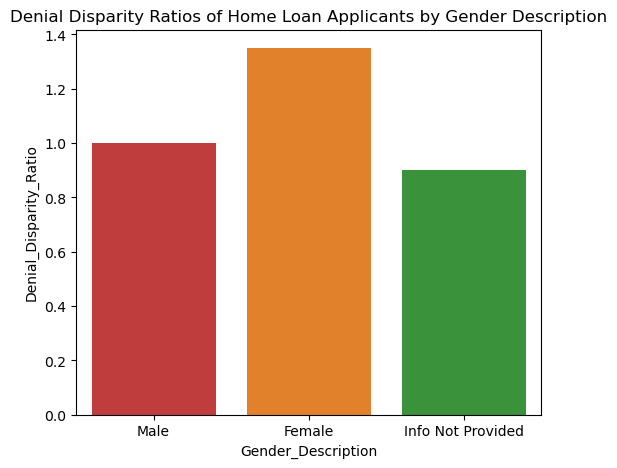

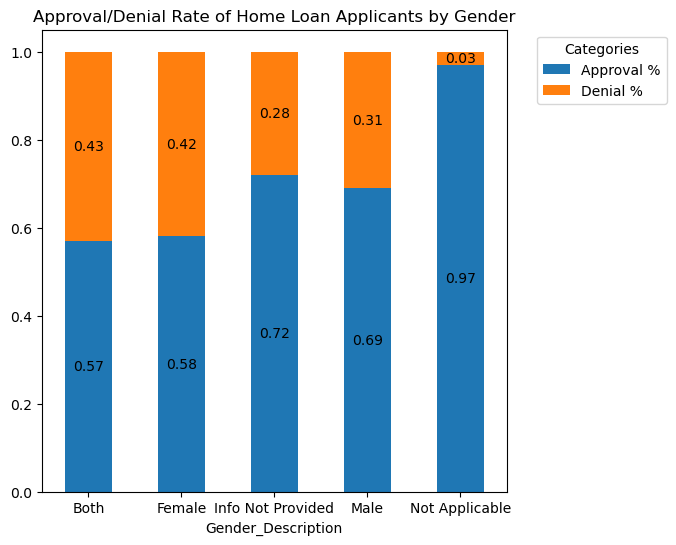

,Gender_Description,Approval %,Denial %,Denial_Disparity_Ratio
0,Both,57.0,43.0,1.39
1,Female,58.0,42.0,1.35
2,Info Not Provided,72.0,28.0,0.90
3,Male,69.0,31.0,1.00
4,Not Applicable,97.0,3.0,0.10


In [149]:
df_approval_perc_gender['Approval %'] = np.round(df_approval_perc_gender['Approval %'], 2)
df_approval_perc_gender['Denial %'] = np.round((1 - df_approval_perc_gender['Approval %']), 2)
df_approval_perc_gender['Denial_Disparity_Ratio'] = np.round(df_approval_perc_gender['Denial %']/(list(df_approval_perc_gender.loc[df_approval_perc_gender['Gender_Description'] == 'Male', 'Denial %'])[0]),2)

fig, ax = plt.subplots(figsize=(6,5))
order_list = ['Male', 'Female', 'Info Not Provided']
g = sns.barplot(x='Gender_Description',y='Denial_Disparity_Ratio', hue='Gender_Description', order=order_list,
            data=df_approval_perc_gender, dodge=False, ax=ax)
g.set(title='Denial Disparity Ratios of Home Loan Applicants by Gender Description')
g.legend_.remove()

df_approval_perc_gender.set_index('Gender_Description', inplace=True)
ax =  df_approval_perc_gender.drop('Denial_Disparity_Ratio', axis=1).plot.bar(stacked=True, figsize=(6, 6), rot=0)

for c in ax.containers:
    ax.bar_label(c, label_type='center')
    
ax.legend(title='Categories', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Approval/Denial Rate of Home Loan Applicants by Gender')

plt.show();

df_approval_perc_gender['Approval %'] = df_approval_perc_gender['Approval %'] * 100
df_approval_perc_gender['Denial %'] = df_approval_perc_gender['Denial %'] * 100
df_approval_perc_gender.reset_index()

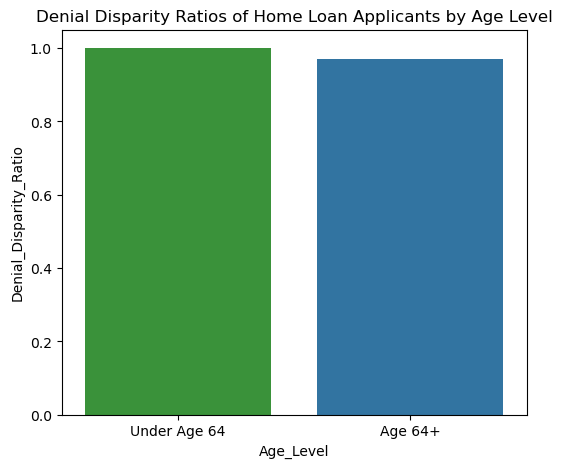

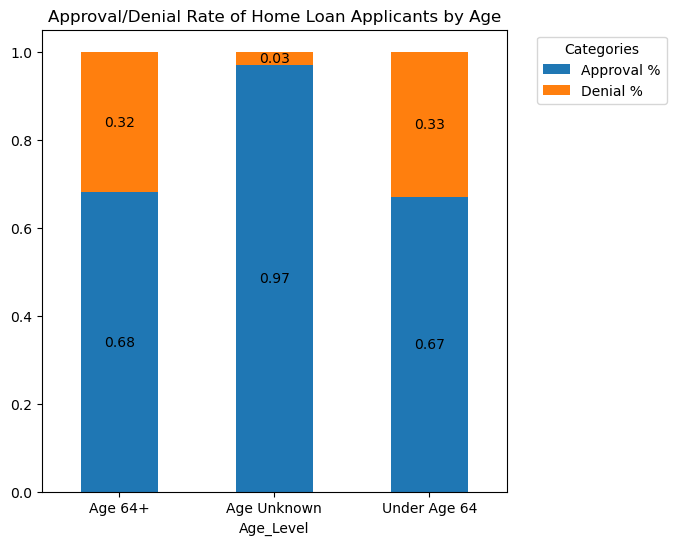

,Approval %,Denial %,Denial_Disparity_Ratio
Age_Level,,,
Age 64+,68.0,32.0,0.97
Age Unknown,97.0,3.0,0.09
Under Age 64,67.0,33.0,1.00


In [150]:
df_approval_perc_age['Approval %'] = np.round(df_approval_perc_age['Approval %'], 2)
df_approval_perc_age['Denial %'] = np.round((1 - df_approval_perc_age['Approval %']), 2)
df_approval_perc_age['Denial_Disparity_Ratio'] = np.round(df_approval_perc_age['Denial %']/(list(df_approval_perc_age.loc[df_approval_perc_age['Age_Level'] == 'Under Age 64', 'Denial %'])[0]),2)

fig, ax = plt.subplots(figsize=(6,5))
order_list = ['Under Age 64', 'Age 64+']
g = sns.barplot(x='Age_Level',y='Denial_Disparity_Ratio', hue='Age_Level', order=order_list,
            data=df_approval_perc_age, dodge=False, ax=ax)
g.set(title='Denial Disparity Ratios of Home Loan Applicants by Age Level')
g.legend_.remove()

df_approval_perc_age.set_index('Age_Level', inplace=True)
ax =  df_approval_perc_age.drop('Denial_Disparity_Ratio', axis=1).plot.bar(stacked=True, figsize=(6, 6), rot=0)

for c in ax.containers:
    ax.bar_label(c, label_type='center')
    
ax.legend(title='Categories', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Approval/Denial Rate of Home Loan Applicants by Age')

plt.show();

df_approval_perc_age['Approval %'] = df_approval_perc_age['Approval %'] * 100
df_approval_perc_age['Denial %'] = df_approval_perc_age['Denial %'] * 100
df_approval_perc_age

In [151]:
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence as influence
from sklearn.preprocessing import MinMaxScaler
from matplotlib import rcParams
import statsmodels.api as sm
import math
from statsmodels.nonparametric.smoothers_lowess import lowess
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [152]:
pip install researchpy


In [153]:
# Check distribution of Gender before transforming

df_lar['Sex_of_Applicant_or_Borrower'].value_counts()

Sex_of_Applicant_or_Borrower
1    78124
2    43785
3     9996
4      509
6       53
Name: count, dtype: int64

In [154]:
app_ethnicity_fields, co_app_ethnicity_fields = extract_ethnicity_fields(df_lar)

In [155]:
app_ethnicity_fields, co_app_ethnicity_fields = extract_ethnicity_fields(df_lar)
app_race_fields, co_app_race_fields = extract_race_fields(df_lar)
df_lar = preprocess_data(df_lar, app_ethnicity_fields + co_app_ethnicity_fields + app_race_fields + co_app_race_fields)

In [156]:
# Now you can apply the functions
df_lar['App_Ethnicity'] = df_lar.apply(lambda row: derive_ethnicity(row, app_ethnicity_fields), axis=1)
df_lar['Co_App_Ethnicity'] = df_lar.apply(lambda row: derive_ethnicity(row, co_app_ethnicity_fields), axis=1)
df_lar['App_Race'] = df_lar.apply(lambda row: derive_race(row, app_race_fields), axis=1)
df_lar['Co_App_Race'] = df_lar.apply(lambda row: derive_race(row, co_app_race_fields), axis=1)

In [157]:
df_lar['App_Ethnicity'] = df_lar['App_Ethnicity'].fillna(df_lar['Ethnicity_of_Applicant_or_Borrower:_1'])
df_lar['App_Ethnicity'] = df_lar['App_Ethnicity'].astype('string')
df_lar['Co_App_Ethnicity'] = df_lar['Co_App_Ethnicity'].fillna(df_lar['Ethnicity_of_Co_Applicant_or_Co_Borrower:_1'])
df_lar['Co_App_Ethnicity'] = df_lar['Co_App_Ethnicity'].astype('string')
df_lar['App_Race'] = df_lar['App_Race'].fillna(df_lar['Race_of_Applicant_or_Borrower:_1'])
df_lar['App_Race'] = df_lar['App_Race'].astype('string')
df_lar['Co_App_Race'] = df_lar['Co_App_Race'].fillna(df_lar['Race_of_Co_Applicant_or_Co_Borrower:_1'])
df_lar['Co_App_Race'] = df_lar['Co_App_Race'].astype('string')

In [158]:
df_lar.head()

,Activity_Year,Legal_Entity_Identifier_(LEI),Loan_Type,Loan_Purpose,Preapproval,Construction_Method,Occupancy_Type,Loan_Amount,Action_Taken,State,County,Census_Tract,Ethnicity_of_Applicant_or_Borrower:_1,Ethnicity_of_Applicant_or_Borrower:_2,Ethnicity_of_Applicant_or_Borrower:_3,Ethnicity_of_Applicant_or_Borrower:_4,Ethnicity_of_Applicant_or_Borrower:_5,Ethnicity_of_Co_Applicant_or_Co_Borrower:_1,Ethnicity_of_Co_Applicant_or_Co_Borrower:_2,Ethnicity_of_Co_Applicant_or_Co_Borrower:_3,Ethnicity_of_Co_Applicant_or_Co_Borrower:_4,Ethnicity_of_Co_Applicant_or_Co_Borrower:_5,Ethnicity_of_Applicant_or_Borrower_Collected_on_the_Basis_of_Visual_Observation_or_Surname,Ethnicity_of_Co_Applicant_or_Co_Borrower_Collected_on_the_Basis_of_Visual_Observation_or_Surname,Race_of_Applicant_or_Borrower:_1,Race_of_Applicant_or_Borrower:_2,Race_of_Applicant_or_Borrower:_3,Race_of_Applicant_or_Borrower:_4,Race_of_Applicant_or_Borrower:_5,Race_of_Co_Applicant_or_Co_Borrower:_1,Race_of_Co_Applicant_or_Co_Borrower:_2,Race_of_Co_Applicant_or_Co_Borrower:_3,Race_of_Co_Applicant_or_Co_Borrower:_4,Race_of_Co_Applicant_or_Co_Borrower:_5,Race_of_Applicant_or_Borrower_Collected_on_the_Basis_of_Visual_Observation_or_Surname,Race_of_Co_Applicant_or_Co_Borrower_Collected_on_the_Basis_of_Visual_Observation_or_Surname,Sex_of_Applicant_or_Borrower,Sex_of_Co_Applicant_or_Co_Borrower,Sex_of_Applicant_or_Borrower_Collected_on_the_Basis_of_Visual_Observation_or_Surname,Sex_of_Co_Applicant_or_Co_Borrower_Collected_on_the_Basis_of_Visual_Observation_or_Surname,Age_of_Applicant_or_Borrower,Age_of_Applicant_>=_62,Age_of_Co_Applicant_or_Co_Borrower,Age_of_Co_Applicant_>=_62,Income,Type_of_Purchaser,Rate_Spread,HOEPA_Status,Lien_Status,Applicant_or_Borrower___Name_and_Version_of_Credit_Scoring_Model,Co_Applicant_or_Co_Borrower___Name_and_Version_of_Credit_Scoring_Model,Reason_for_Denial:_1,Reason_for_Denial:_2,Reason_for_Denial:_3,Reason_for_Denial:_4,Total_Loan_Costs,Total_Points_and_Fees,Origination_Charges,Discount_Points,Lender_Credits,Interest_Rate,Prepayment_Penalty_Term,Debt_to_Income_Ratio,Combined_Loan_to_Value_Ratio,Loan_Term,Introductory_Rate_Period,Balloon_Payment,Interest_Only_Payments,Negative_Amortization,Other_Non_amortizing_Features,Property_Value,Manufactured_Home_Secured_Property_Type,Manufactured_Home_Land_Property_Interest,Total_Units,Multifamily_Affordable_Units,Submission_of_Application,Initially_Payable_to_Your_Institution,Automated_Underwriting_System:_1,Automated_Underwriting_System:_2,Automated_Underwriting_System:_3,Automated_Underwriting_System:_4,Automated_Underwriting_System:_5,Reverse_Mortgage,Open_End_Line_of_Credit,Business_or_Commercial_Purpose,gender_code,Gender_Description,Age_Level,App_Ethnicity,Co_App_Ethnicity,App_Race,Co_App_Race
0,2023,AD6GFRVSDT01YPT1CS68,1,4,2,1,1,35000,Loan Purchased by your Instituion,GA,13239.0,1.323996e+10,4,X,X,X,X,5,X,X,X,X,3,4,7,X,X,X,X,8,X,X,X,X,3,4,4,5,3,4,8888,NaN,9999,NaN,NaN,0,NaN,2,1,9,9,10,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,8.375,NaN,NaN,NaN,360,NaN,2,2,2,2,75000.0,3,5,1,NaN,3,3,6,NaN,NaN,NaN,NaN,2,2,2,4,Not Applicable,Age Unknown,4,5,7,8
1,2023,AD6GFRVSDT01YPT1CS68,3,31,2,1,1,155000,Loan Purchased by your Instituion,NM,35001.0,3.500100e+10,4,X,X,X,X,5,X,X,X,X,3,4,7,X,X,X,X,8,X,X,X,X,3,4,4,5,3,4,8888,NaN,9999,NaN,NaN,0,NaN,2,1,9,9,10,NaN,NaN,NaN,1876.52,NaN,0.0,NaN,NaN,5.000,NaN,NaN,NaN,360,NaN,2,2,2,2,215000.0,3,5,1,NaN,3,3,6,NaN,NaN,NaN,NaN,2,2,2,4,Not Applicable,Age Unknown,4,5,7,8
2,2023,AD6GFRVSDT01YPT1CS68,1,2,2,1,1,35000,Loan Purchased by your Instituion,IN,18177.0,1.817700e+10,4,X,X,X,X,5,X,X,X,X,3,4,7,X,X,X,X,8,X,X,X,X,3,4,4,5,3,4,8888,NaN,9999,NaN,NaN,0,NaN,2,1,9,9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.125,NaN,NaN,NaN,360,NaN,2,2,2,2,125000.0,3,5,1,NaN,3,3,6,NaN,NaN,NaN,NaN,2,2,2,4,Not Applicable,Age Unknown,4,5,7,8
3,2023,AD6GFRVSDT01YPT1CS68,2,1,2,1,1,65000,Loan Purchased by your Instituion,TX,48061.0,4.806101e+10,4,X,X,X,X,5,X,X,X,X,3,4,7,X,X,X,X,8,X,X,X,X,3,4,4,5,3,4,8888,NaN,9999,NaN,NaN,0

In [159]:
df_lar['Co_App_Race'].value_counts()

Co_App_Race
8    77246
5    39189
6     8580
2     4369
3     2472
1      311
4      149
7      115
X       36
Name: count, dtype: Int64

In [160]:
for i, r in df_lar.iterrows():
    if r['App_Race'].isdigit() and int(r['App_Race']) <= 5:
        df_lar.at[i, 'Race_Calc'] = r['App_Race']
    elif r['Co_App_Race'].isdigit() and int(r['Co_App_Race']) <= 5:
        df_lar.at[i, 'Race_Calc'] = r['Co_App_Race']
    else:
        df_lar.at[i, 'Race_Calc'] = None

In [161]:
df_lar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132467 entries, 0 to 132466
Data columns (total 93 columns):
 #   Column                                                                                            Non-Null Count   Dtype  
---  ------                                                                                            --------------   -----  
 0   Activity_Year                                                                                     132467 non-null  int64  
 1   Legal_Entity_Identifier_(LEI)                                                                     132467 non-null  object 
 2   Loan_Type                                                                                         132467 non-null  int64  
 3   Loan_Purpose                                                                                      132467 non-null  int64  
 4   Preapproval                                                                                       132467 non-null  i

In [162]:
df_lar = merge_race_mapping(df_lar)

In [163]:
df_lar['Race'].value_counts()

Race
White                                        90535
Black                                        10659
Asian                                        10354
American Indian or Alaska Native              1103
Native Hawaiian or Other Pacific Islander      440
Name: count, dtype: int64

In [164]:
#df_lar['Race'] = df_lar.apply(apply_ethnicity_logic, axis=1)

In [165]:
df_lar['Race'].value_counts()

Race
White                                        90535
Black                                        10659
Asian                                        10354
American Indian or Alaska Native              1103
Native Hawaiian or Other Pacific Islander      440
Name: count, dtype: int64

In [166]:
# Define the race mapping
race_mapping = {
    'American Indian or Alaska Native': 'American Indian or Alaska Native',
    'Asian': 'Asian',
    'Black': 'Black',
    'Hispanic and Latino': 'Hispanic or Latino',  # Adjusted to match the values in the data
    'Native Hawaiian or Other Pacific Islander': 'Native Hawaiian or Other Pacific Islander',
    'White': 'White'
}

# Add Race column to your DataFrame based on the mapping
df_lar['Race'] = df_lar['App_Race'].map(race_mapping)

# Check the Race column to ensure it has been added correctly
print(df_lar['Race'].value_counts())


Series([], Name: count, dtype: int64)


In [167]:
#df_lar = clean_age_data(df_lar)
#df_lar = derive_age_level(df_lar)
#df_lar = derive_gender_code(df_lar)
#df_lar = merge_gender_mapping(df_lar)

In [168]:
# Map Action Taken codes back to categorical values
df_lar['Action_Taken'] = df_lar['Action_Taken'].apply(lambda x: map_action_taken(x))

# Check distribution
df_lar['Action_Taken'].value_counts(dropna=False)

Action_Taken
Value Not Found    132467
Name: count, dtype: int64

In [169]:
approval_percentage_race = df_lar.loc[df_lar['Action_Taken'] == 'Approved'].groupby('Race')['Legal_Entity_Identifier_(LEI)'].count()/(df_lar.loc[df_lar['Action_Taken'] == 'Approved'].groupby('Race')['Legal_Entity_Identifier_(LEI)'].count() + df_lar.loc[df_lar['Action_Taken'] == 'Denied'].groupby('Race')['Legal_Entity_Identifier_(LEI)'].count())
approval_percentage_gender = df_lar.loc[df_lar['Action_Taken'] == 'Approved'].groupby('Gender_Description')['Legal_Entity_Identifier_(LEI)'].count()/(df_lar.loc[df_lar['Action_Taken'] == 'Approved'].groupby('Gender_Description')['Legal_Entity_Identifier_(LEI)'].count() + df_lar.loc[df_lar['Action_Taken'] == 'Denied'].groupby('Gender_Description')['Legal_Entity_Identifier_(LEI)'].count())
approval_percentage_age = df_lar.loc[df_lar['Action_Taken'] == 'Approved'].groupby('Age_Level')['Legal_Entity_Identifier_(LEI)'].count()/(df_lar.loc[df_lar['Action_Taken'] == 'Approved'].groupby('Age_Level')['Legal_Entity_Identifier_(LEI)'].count() + df_lar.loc[df_lar['Action_Taken'] == 'Denied'].groupby('Age_Level')['Legal_Entity_Identifier_(LEI)'].count())


In [170]:
df_approval_perc_race = pd.DataFrame({'Race':approval_percentage_race.index, 'Approval %':approval_percentage_race.values})
df_approval_perc_gender = pd.DataFrame({'Gender_Description':approval_percentage_gender.index, 'Approval %':approval_percentage_gender.values})
df_approval_perc_age = pd.DataFrame({'Age_Level':approval_percentage_age.index, 'Approval %':approval_percentage_age.values})

In [171]:
df_approval_perc_race['Approval %'] = np.round(df_approval_perc_race['Approval %'], 2)
df_approval_perc_race['Denial %'] = np.round((1 - df_approval_perc_race['Approval %']), 2)

In [172]:
df_approval_perc_race['Denial %'] = np.round((1 - df_approval_perc_race['Approval %']), 2)

In [173]:
print(df_approval_perc_race['Race'].unique())


[]


In [174]:
df_approval_perc_race.head()

,Race,Approval %,Denial %


In [175]:
df_approval_perc_race.head()

,Race,Approval %,Denial %


In [176]:
df_approval_perc_race['Denial_Disparity_Ratio'] = np.round(df_approval_perc_race['Denial %']/(list(df_approval_perc_race.loc[df_approval_perc_race['Race'] == 'White', 'Denial %'])[0]),2)

IndexError: list index out of range

In [177]:
# Check if 'White' race exists in the DataFrame
if 'White' in df_approval_perc_race['Race'].values:
    # Calculate Denial Disparity Ratio
    white_denial_percentage = df_approval_perc_race.loc[df_approval_perc_race['Race'] == 'White', 'Denial %'].values[0]
    df_approval_perc_race['Denial_Disparity_Ratio'] = np.round(df_approval_perc_race['Denial %'] / white_denial_percentage, 2)
else:
    # Handle the case where 'White' race is not present
    print("'White' race not found in the DataFrame.")


'White' race not found in the DataFrame.


In [178]:
print(df_approval_perc_race['Race'].str.strip().unique())


[]


In [179]:
print(df_approval_perc_race['Race'].unique())


[]


In [180]:
approval_percentage_race['Denial_Disparity_Ratio'] = np.round(approval_percentage_race['Denial %']/(list(approval_percentage_race.loc[approval_percentage_race['Race'] == 'White', 'Denial %'])[0]),2)

KeyError: 'Denial %'

In [181]:
df_approval_perc_race = df_approval_perc_race.loc[(df_approval_perc_race['Race'] != 'American Indian or Alaska Native') &
                                                  (df_approval_perc_race['Race'] != 'Native Hawaiian or Other Pacific Islander')]
df_approval_perc_race

,Race,Approval %,Denial %


In [182]:
df_approval_perc_race['Approval %'] = np.round(df_approval_perc_race['Approval %'], 2)
df_approval_perc_race['Denial %'] = np.round((1 - df_approval_perc_race['Approval %']), 2)
df_approval_perc_race['Denial_Disparity_Ratio'] = np.round(df_approval_perc_race['Denial %']/(list(df_approval_perc_race.loc[df_approval_perc_race['Race'] == 'White', 'Denial %'])[0]),2)

fig, ax = plt.subplots(figsize=(6,5))
order_list = ['White', 'Black', 'Asian','Hispanic and Latino']
g = sns.barplot(x='Race',y='Denial_Disparity_Ratio', hue='Race',
            data=df_approval_perc_race, dodge=False, ax=ax, order=order_list)
g.set(title='Denial Disparity Ratios of Home Loan Applicants by Race')
g.legend_.remove()
plt.xticks(rotation=45)
plt.show();

IndexError: list index out of range

In [183]:
df_approval_perc_race['Approval %'] = df_approval_perc_race['Approval %'] * 100
df_approval_perc_race['Denial %'] = df_approval_perc_race['Denial %'] * 100
df_approval_perc_race

,Race,Approval %,Denial %


In [184]:
df_approval_perc_race.set_index('Race', inplace=True)
ax =  df_approval_perc_race.drop('Denial_Disparity_Ratio', axis=1).plot.bar(stacked=True, figsize=(12, 8), rot=45)

for c in ax.containers:
    ax.bar_label(c, label_type='center')
    
ax.legend(title='Categories', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Approval/Denial Rate of Home Loan Applicants by Race')
plt.show();

KeyError: "['Denial_Disparity_Ratio'] not found in axis"

In [185]:
import pandas as pd
import numpy as np
import scipy.stats as stats

# Contingency Table for Race
race_contingency_table = pd.crosstab(cleaned_lar['Action_Taken'], cleaned_lar['Race'])

# Chi-Square test for race
chi2_race, p_value_race, dof_race, expected_race = stats.chi2_contingency(race_contingency_table)

# Print results
print("Contingency Table for Race:")
print(race_contingency_table)
print("\nChi-Square Statistic:", chi2_race)
print("P-value:", p_value_race)
print("Degrees of Freedom:", dof_race)
print("\nExpected Frequencies:")
print(expected_race)


NameError: name 'cleaned_lar' is not defined

In [74]:
# Chi-Square test for age
age_contingency_table = pd.crosstab(df_lar['Action_Taken'], df_lar['Age_Level'])

chi2_age, p_value_age, dof_age, expected_age = stats.chi2_contingency(age_contingency_table)

print("Contingency Table for Age:")
print(age_contingency_table)
print("\nChi-Square Statistic:", chi2_age)
print("P-value:", p_value_age)
print("Degrees of Freedom:", dof_age)
print("\nExpected Frequencies:")
print(expected_age)


Contingency Table for Age:
Age_Level        Age 64+  Age Unknown  Under Age 64
Action_Taken                                       
Value Not Found    25756          509        106202

Chi-Square Statistic: 0.0
P-value: 1.0
Degrees of Freedom: 0

Expected Frequencies:
[[ 25756.    509. 106202.]]


In [75]:
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(df_lar['Action_Taken'], df_lar['Gender_Description'])

# Display the contingency table
print("Contingency Table:")
print(contingency_table)

# Perform the chi-square test of independence
chi2, p, dof, expected = chi2_contingency(contingency_table)
print("\nChi-Square Statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)
print("\nExpected Frequencies:")
print(expected)


Contingency Table:
Gender_Description  Both  Female  Info Not Provided   Male  Not Applicable
Action_Taken                                                              
Value Not Found       36   29035               9940  92947             509

Chi-Square Statistic: 0.0
P-value: 1.0
Degrees of Freedom: 0

Expected Frequencies:
[[3.6000e+01 2.9035e+04 9.9400e+03 9.2947e+04 5.0900e+02]]
